# Рекомендация мобильного телефона

In [34]:
import os
import random
import numpy as np
import pandas as pd
from scipy import sparse

import lightfm
from lightfm import LightFM, cross_validation
from lightfm.evaluation import precision_at_k, auc_score

from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#Прочитаем и объединим данные
cellphone_df = pd.read_csv('cellphones data.csv')
rating_df  = pd.read_csv('cellphones ratings.csv')
user_df = pd.read_csv('cellphones users.csv')

# Объединим рейтинги df и mobilephone_df по mobilephone_id

In [37]:
df = pd.merge(rating_df, cellphone_df, on='cellphone_id')

# Объединим rating_df и user_df по user_id

In [38]:
df = pd.merge(df, user_df, on='user_id')

In [39]:
df

,user_id,cellphone_id,rating,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release date,age,gender,occupation
0,0,30,1,Motorola,Moto G Play (2021),Android,32,3,1.42,13,5,5000,6.5,204,159,14/01/2021,38,Female,Data analyst
1,0,5,3,Apple,iPhone XR,iOS,64,3,4.22,12,7,2942,6.1,194,236,26/10/2018,38,Female,Data analyst
2,0,10,9,Samsung,Galaxy S22,Android,128,8,8.81,50,10,3700,6.1,167,528,25/02/2022,38,Female,Data analyst
3,0,9,3,Samsung,Galaxy A53,Android,128,6,3.79,64,32,5000,6.5,189,312,24/03/2022,38,Female,Data analyst
4,0,23,2,Vivo,X80 Pro,Android,256,8,9.81,50,32,4700,6.7,215,872,29/04/2022,38,Female,Data analyst
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,113,27,1,Xiaomi,Poco F4,Android,128,8,6.98,64,20,4500,6.6,195,428,27/07/2022,56,Female,retail
986,113,29,2,Motorola,Moto G Stylus (2022),Android,128,6,2.30,50,16,5000,6.8,215,500,27/04/2022,56,Female,retail
987,113,21,1,OnePlus,10T,Android,128,8,11.00,50,16,4800,6.7,204,649,06/08/2022,56,Female,retail
988,113,14,5,Samsung,Galaxy Z Fold 3,Android,256,12,6.35,12,4,4400,7.6,271,1799,11/08/2021,56,Female,retail


In [40]:
df.isna().sum()

user_id              0
cellphone_id         0
rating               0
brand                0
model                0
operating system     0
internal memory      0
RAM                  0
performance          0
main camera          0
selfie camera        0
battery size         0
screen size          0
weight               0
price                0
release date         0
age                  0
gender               0
occupation          10
dtype: int64

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

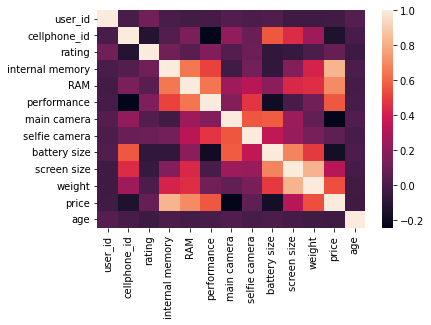

In [42]:
sns.heatmap(df.corr())

In [43]:
df.head().style.background_gradient(cmap = "inferno")

,user_id,cellphone_id,rating,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release date,age,gender,occupation
0,0,30,1,Motorola,Moto G Play (2021),Android,32,3,1.420000,13,5,5000,6.500000,204,159,14/01/2021,38,Female,Data analyst
1,0,5,3,Apple,iPhone XR,iOS,64,3,4.220000,12,7,2942,6.100000,194,236,26/10/2018,38,Female,Data analyst
2,0,10,9,Samsung,Galaxy S22,Android,128,8,8.810000,50,10,3700,6.100000,167,528,25/02/2022,38,Female,Data analyst
3,0,9,3,Samsung,Galaxy A53,Android,128,6,3.790000,64,32,5000,6.500000,189,312,24/03/2022,38,Female,Data analyst
4,0,23,2,Vivo,X80 Pro,Android,256,8,9.810000,50,32,4700,6.700000,215,872,29/04/2022,38,Female,Data analyst


In [ ]:
df.describe().T.style.background_gradient(cmap = "viridis")

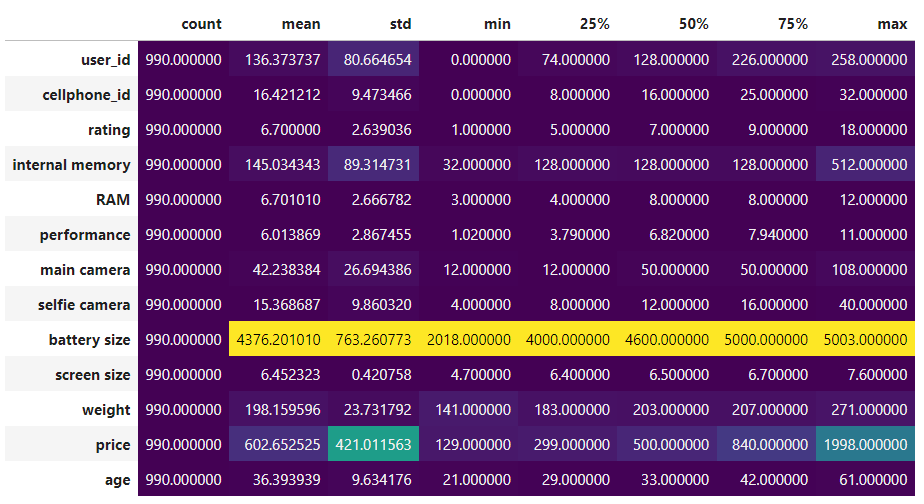

In [45]:
df.columns

Index(['user_id', 'cellphone_id', 'rating', 'brand', 'model',
       'operating system', 'internal memory', 'RAM', 'performance',
       'main camera', 'selfie camera', 'battery size', 'screen size', 'weight',
       'price', 'release date', 'age', 'gender', 'occupation'],
      dtype='object')

# Построение рекомендательной системы

In [46]:
df_playlist = pd.read_csv('../input/cellphones-recommendations/cellphones ratings.csv', 
                          error_bad_lines=False, 
                          warn_bad_lines=False,
                          skiprows=lambda i: i>0 and random.random() > 0.50)
df_playlist

,user_id,cellphone_id,rating
0,0,30,1
1,0,10,9
2,0,16,2
3,0,19,1
4,0,3,10
...,...,...,...
469,258,22,9
470,258,6,7
471,258,29,6
472,258,31,5


# Предварительная обработка данных

In [47]:
df_playlist =df_playlist.groupby('cellphone_id').filter(lambda x: len(x)>=4)
df_playlist

,user_id,cellphone_id,rating
0,0,30,1
1,0,10,9
2,0,16,2
3,0,19,1
4,0,3,10
...,...,...,...
469,258,22,9
470,258,6,7
471,258,29,6
472,258,31,5


In [48]:
df_playlist = df_playlist[df_playlist.groupby('user_id').cellphone_id.transform('nunique')>=4]
df_playlist

,user_id,cellphone_id,rating
0,0,30,1
1,0,10,9
2,0,16,2
3,0,19,1
4,0,3,10
...,...,...,...
469,258,22,9
470,258,6,7
471,258,29,6
472,258,31,5


# Определим функции

In [49]:
def create_interaction_matrix(df,user_col, item_col, rating_col, norm= False, threshold = None):
    '''
     Функция для создания кадра данных матрицы взаимодействия из взаимодействий транзакционного типа
     Требуемый ввод -
         - df = Pandas DataFrame, содержащего взаимодействие пользователя с элементом
         - user_col = имя столбца, содержащего идентификатор пользователя
         - item_col = имя столбца, содержащего идентификатор элемента
         - колонка рейтинга = имя столбца, содержащего отзывы пользователей о взаимодействии с данным элементом
         - norm (необязательно) = True, если требуется нормализация рейтингов
         - пороговое значение (обязательно, если норма = Истина) = значение, выше которого рейтинг является благоприятным
     Ожидаемый результат -
     '''
    interactions = df.groupby([user_col, item_col])[rating_col] \
            .sum().unstack().reset_index(). \
            fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

In [51]:
def create_user_dict(interactions):
    '''
     Функция для создания пользовательского словаря на основе их индекса и номера в наборе данных взаимодействия.
     Требуемый ввод -
         взаимодействия — набор данных, созданный create_interaction_matrix
     Ожидаемый результат -
         user_dict — вывод типа словаря, содержащий в качестве ключа interface_index, а в качестве значения — user_id.
     '''
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

In [52]:
def create_item_dict(df,id_col,name_col):
    '''
     Функция для создания словаря элементов на основе их item_id и имени элемента.
     Требуемый ввод -
         - df = кадр данных Pandas с информацией об элементе
         - id_col = имя столбца, содержащее уникальный идентификатор элемента
         - name_col = имя столбца, содержащее имя элемента
     Ожидаемый результат -
         item_dict = вывод типа словаря, содержащий item_id в качестве ключа и item_name в качестве значения
     '''
    item_dict ={}
    for i in range(df.shape[0]):
        item_dict[(df.loc[i,id_col])] = df.loc[i,name_col]
    return item_dict


In [53]:
def runMF(interactions, n_components=30, loss='warp', k=15, epoch=30,n_jobs = 4):
    '''
     Функция для запуска алгоритма матричной факторизации
     Требуемый ввод -
         - взаимодействия = набор данных, созданный с помощью create_interaction_matrix
         - n_components = количество вложений, которые вы хотите создать для определения элемента и пользователя
         - потеря = функция потерь, другие варианты - логистические, brp
         - эпоха = количество эпох для запуска
         - n_jobs = количество ядер, используемых для выполнения
     Ожидаемый результат -
         Модель — обученная модель
     '''
    
    model = LightFM(no_components= n_components, loss=loss,k=k)
    model.fit(x,epochs=epoch,num_threads = n_jobs)
    return model

In [54]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    '''
     Функция для выдачи пользовательских рекомендаций
     Требуемый ввод -
         - модель = Обученная матричная модель факторизации
         - взаимодействия = набор данных, используемый для обучения модели
         - user_id = идентификатор пользователя, для которого нам нужно сгенерировать рекомендацию
         - user_dict = ввод словарного типа, содержащий interface_index в качестве ключа и user_id в качестве значения
         - item_dict = ввод словарного типа, содержащий item_id в качестве ключа и item_name в качестве значения
         - порог = значение, выше которого рейтинг является благоприятным в новой матрице взаимодействия
         - nrec_items = Количество необходимых выходных рекомендаций
     Ожидаемый результат -
         - Распечатывает список товаров, которые данный пользователь уже купил
         - Распечатывает список из N рекомендуемых элементов, которые, надеюсь, заинтересуют пользователя.
     '''
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index) \
                       .sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print("Список товаров, которые данный пользователь уже купил:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Список из N рекомендуемых элементов, которые, надеюсь, заинтересуют пользователя:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1
    return return_score_list

# Переформатируем данные

In [55]:
interactions = create_interaction_matrix(df = df_playlist, user_col = "user_id", item_col = 'cellphone_id', rating_col = 'rating', norm= False, threshold = None)
interactions.head()

cellphone_id,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,6.0
6,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,9.0,0.0,3.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,5.0


In [56]:
user_dict = create_user_dict(interactions=interactions)
print(user_dict)

{0: 0, 1: 1, 6: 2, 10: 3, 12: 4, 16: 5, 24: 6, 25: 7, 26: 8, 28: 9, 29: 10, 30: 11, 32: 12, 36: 13, 37: 14, 38: 15, 52: 16, 56: 17, 79: 18, 80: 19, 84: 20, 91: 21, 95: 22, 98: 23, 99: 24, 100: 25, 104: 26, 105: 27, 106: 28, 110: 29, 111: 30, 112: 31, 114: 32, 115: 33, 119: 34, 123: 35, 124: 36, 126: 37, 128: 38, 129: 39, 137: 40, 140: 41, 142: 42, 143: 43, 144: 44, 145: 45, 148: 46, 152: 47, 156: 48, 160: 49, 162: 50, 169: 51, 178: 52, 183: 53, 194: 54, 200: 55, 203: 56, 204: 57, 208: 58, 211: 59, 230: 60, 232: 61, 233: 62, 234: 63, 235: 64, 236: 65, 237: 66, 238: 67, 240: 68, 243: 69, 244: 70, 246: 71, 251: 72, 252: 73, 253: 74, 254: 75, 255: 76, 256: 77, 257: 78, 258: 79}


In [57]:
df_playlist

,user_id,cellphone_id,rating
0,0,30,1
1,0,10,9
2,0,16,2
3,0,19,1
4,0,3,10
...,...,...,...
469,258,22,9
470,258,6,7
471,258,29,6
472,258,31,5


In [58]:
df_item=pd.read_csv('../input/cellphones-recommendations/cellphones data.csv')

In [59]:
item_dict = create_item_dict(df=df_item, id_col='cellphone_id', name_col='model')
print(item_dict)

{0: 'iPhone SE (2022)', 1: 'iPhone 13 Mini', 2: 'iPhone 13', 3: 'iPhone 13 Pro', 4: 'iPhone 13 Pro Max', 5: 'iPhone XR', 6: 'Zenfone 8', 7: 'Galaxy A13', 8: 'Galaxy A32', 9: 'Galaxy A53', 10: 'Galaxy S22', 11: 'Galaxy S22 Plus', 12: 'Galaxy S22 Ultra', 13: 'Galaxy Z Flip 3', 14: 'Galaxy Z Fold 3', 15: 'Pixel 6 \xa0', 16: 'Pixel 6a', 17: 'Pixel 6 Pro\xa0', 18: 'Nord N20', 19: 'Nord 2T', 20: '10 Pro', 21: '10T', 22: 'Find X5 Pro', 23: 'X80 Pro', 24: 'Redmi Note 11', 25: '11T Pro', 26: '12 Pro', 27: 'Poco F4', 28: 'Xperia Pro', 29: 'Moto G Stylus (2022)', 30: 'Moto G Play (2021)', 31: 'Moto G Pure', 32: 'Moto G Power (2022)'}


In [60]:
x = sparse.csr_matrix(interactions.values)
train, test = lightfm.cross_validation.random_train_test_split(x, test_percentage=0.2, random_state=None)

### Построим модель

In [61]:
%time
model = runMF(interactions = train,
                 n_components = 30,
                 loss = 'warp',
                 k = 15,
                 epoch = 30,
                 n_jobs = 4)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.3 µs


# Примеры

In [62]:
rec_list = sample_recommendation_user(model = model, 
                                      interactions = interactions, 
                                      user_id = 0, 
                                      user_dict = user_dict,
                                      item_dict = item_dict, 
                                      threshold = 0,
                                      nrec_items = 10,
                                      show = True)

Список товаров, которые данный пользователь уже купил:
1- Moto G Play (2021)
2- Nord 2T
3- Pixel 6a
4- Galaxy S22
5- iPhone 13 Pro

 Список из N рекомендуемых элементов, которые, надеюсь, заинтересуют пользователя:
1- 12 Pro
2- Redmi Note 11
3- iPhone 13
4- iPhone XR
5- Moto G Pure
6- Xperia Pro
7- Galaxy S22 Plus
8- iPhone SE (2022)
9- Galaxy A32
10- Galaxy A13


In [63]:
rec_list = sample_recommendation_user(model = model, 
                                      interactions = interactions, 
                                      user_id = 6, 
                                      user_dict = user_dict,
                                      item_dict = item_dict, 
                                      threshold = 0,
                                      nrec_items = 10,
                                      show = True)

Список товаров, которые данный пользователь уже купил:
1- X80 Pro
2- Nord 2T
3- Galaxy A32
4- iPhone 13 Mini

 Список из N рекомендуемых элементов, которые, надеюсь, заинтересуют пользователя:
1- Galaxy A53
2- Xperia Pro
3- Galaxy S22 Plus
4- iPhone XR
5- Pixel 6  
6- Poco F4
7- iPhone 13 Pro
8- Moto G Stylus (2022)
9- Galaxy Z Flip 3
10- 11T Pro
